# Exploring the TCIR dataset
[TCIR](https://www.csie.ntu.edu.tw/~htlin/program/TCIR/) stands for Tropical Cyclone Image-o-intensity Regression. The dataset was assembled and made public by Dr. Hsuan-Tien Lin, of the CCLab at NTU.

[Reference paper](https://dl.acm.org/doi/10.1145/3219819.3219926):  
B. Chen, B.-F. Chen, et H.-T. Lin, « Rotation-blended CNNs on a New Open Dataset for Tropical Cyclone Image-to-intensity Regression », in Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, in KDD ’18. New York, NY, USA: Association for Computing Machinery, juill. 2018, p. 90‑99. doi: 10.1145/3219819.3219926.

The dataset includes Infrared (IR), Water Vapor (WV), Visible (VIS) and Passive Microwave (PMW or MW) rainrates images centered on tropical cyclones. It includes 1285 TCs in all basins, between 2003 and 2016. It also includes best-track data from JTWC and HURDAT2.

# Imports and paths

In [1]:
import xarray as xr
import netCDF4 as ncdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [2]:
%cd ..

/home/cdauvill/inria/tc_probabilistic_forecasting


In [3]:
with open("config.yml", 'r') as cfg_file:
    cfg = yaml.safe_load(cfg_file)
_TCIR_PATH_ = cfg['paths']['tcir']

# Loading the data

In [4]:
# load "info" as pandas dataframe
data_info = pd.read_hdf(_TCIR_PATH_, key="info", mode='r')
data_info.head()

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
0,ATLN,201701L,-50.3,35.8,2017041606,55.0,270.0,992.0
1,ATLN,201701L,-49.9,35.5,2017041609,55.0,270.0,990.0
2,ATLN,201701L,-49.5,35.1,2017041612,55.0,270.0,989.0
3,ATLN,201701L,-49.1,34.8,2017041615,55.0,262.5,988.0
4,ATLN,201701L,-48.7,34.4,2017041618,55.0,255.0,986.0


In [5]:
# Load the datacubes
dataset = xr.open_dataset(_TCIR_PATH_)
dataset

<xarray.Dataset>
Dimensions:  (phony_dim_4: 4580, phony_dim_5: 201, phony_dim_6: 201,
              phony_dim_7: 4)
Dimensions without coordinates: phony_dim_4, phony_dim_5, phony_dim_6,
                                phony_dim_7
Data variables:
    matrix   (phony_dim_4, phony_dim_5, phony_dim_6, phony_dim_7) float32 ...

In [6]:
datacube = dataset['matrix']

# Preprocessing the tabular data

First, we'll rename some of the columns so thay they match the pipeline, which was originally developped for IBTrACS:

In [7]:
data_info = data_info.rename({'data_set': 'BASIN',
                              'ID': 'SID',
                              'time': 'ISO_TIME',
                              'lat': 'LAT',
                              'lon': 'LON',
                              'Vmax': 'INTENSITY'
                             }, axis="columns")
data_info

,BASIN,SID,LON,LAT,ISO_TIME,INTENSITY,R35_4qAVG,MSLP
0,ATLN,201701L,-50.3,35.8,2017041606,55.0,270.0,992.0
1,ATLN,201701L,-49.9,35.5,2017041609,55.0,270.0,990.0
2,ATLN,201701L,-49.5,35.1,2017041612,55.0,270.0,989.0
3,ATLN,201701L,-49.1,34.8,2017041615,55.0,262.5,988.0
4,ATLN,201701L,-48.7,34.4,2017041618,55.0,255.0,986.0
...,...,...,...,...,...,...,...,...
4575,WPAC,201733W,105.0,8.4,2017122600,20.0,0.0,1007.0
4576,WPAC,201733W,104.7,8.4,2017122603,20.0,0.0,1007.0
4577,WPAC,201733W,104.4,8.4,2017122606,20.0,0.0,1007.0
4578,WPAC,201733W,104.0,8.4,2017122609,18.0,0.0,1009.0


We now need to convert the ```ISO_TIME``` column from string to an actual iso time coordinate:

In [8]:
data_info['ISO_TIME'] = pd.to_datetime(data_info['ISO_TIME'], format='%Y%m%d%H')
data_info

,BASIN,SID,LON,LAT,ISO_TIME,INTENSITY,R35_4qAVG,MSLP
0,ATLN,201701L,-50.3,35.8,2017-04-16 06:00:00,55.0,270.0,992.0
1,ATLN,201701L,-49.9,35.5,2017-04-16 09:00:00,55.0,270.0,990.0
2,ATLN,201701L,-49.5,35.1,2017-04-16 12:00:00,55.0,270.0,989.0
3,ATLN,201701L,-49.1,34.8,2017-04-16 15:00:00,55.0,262.5,988.0
4,ATLN,201701L,-48.7,34.4,2017-04-16 18:00:00,55.0,255.0,986.0
...,...,...,...,...,...,...,...,...
4575,WPAC,201733W,105.0,8.4,2017-12-26 00:00:00,20.0,0.0,1007.0
4576,WPAC,201733W,104.7,8.4,2017-12-26 03:00:00,20.0,0.0,1007.0
4577,WPAC,201733W,104.4,8.4,2017-12-26 06:00:00,20.0,0.0,1007.0
4578,WPAC,201733W,104.0,8.4,2017-12-26 09:00:00,18.0,0.0,1009.0


We'll also convert the intensity from knots to m/s:

In [9]:
data_info['INTENSITY'] = data_info['INTENSITY'] * 0.514444

# Selecting every 6h time step
The dataset includes points every 3 hours. However, the best-track data given in the information dataset comes from agencies such as the JTWC, whose best tracks's true temporal resolution is 6h. The data is linearly interpolated to 3h. Therefore, using all points would artificially make the problem easier. To avoid that, we'll only select points at 0000Z, 0600Z, 1200Z and 1800Z to obtain a temporal resolution of 6h without a linear relationship between successive labels:

In [10]:
# Select the points in the info
data_info = data_info[data_info['ISO_TIME'].dt.hour.isin([0, 6, 12, 18])]
# Select the corresponding entries in the datacube
datacube = datacube.isel(phony_dim_4=data_info.index)
# Reset the index of data_info to keep the matching between it and datacube.isel
data_info = data_info.reset_index()

In [11]:
print(data_info.shape)
print(datacube.shape)

(2337, 9)
(2337, 201, 201, 4)


# Preprocessing the datacube

## Renaming the dimensions

In [12]:
datacube = datacube.rename({"phony_dim_4": "sid_time",
                            "phony_dim_5": "v_pixel_offset",
                            "phony_dim_6": "h_pixel_offset",
                            "phony_dim_7": "variable"})

## Removing the WV and visible channels
The Water vapor and Visble channels do not supposedly provide more information than the Infrared channels, which is the one mostly used in traditional methods. To avoid using correlated input data, we'll discard them. Besides, the Visible channel is very unstable due to daylight.

In [13]:
datacube = datacube.drop_sel(variable=[1, 2])

## Adding coordinates
Right now, the datacube has dimensions but no coordinates. First, we'll add coordinates for the latitude and longitude dimensions.
Since the latitudes and longitudes are different for each sample, we cannot directly use them as coordinates. Instead we'll use offset, in pixels, from the center of the image:

In [14]:
img_side_len = datacube.shape[1]
offset = np.arange(-(img_side_len // 2), img_side_len // 2 + 1)
# Horizontal pixel offset
datacube = datacube.assign_coords(h_pixel_offset=('h_pixel_offset', offset),
                                  v_pixel_offset=('v_pixel_offset', offset))
datacube

<xarray.DataArray 'matrix' (sid_time: 2337, v_pixel_offset: 201,
                            h_pixel_offset: 201, variable: 2)>
[188834274 values with dtype=float32]
Coordinates:
  * h_pixel_offset  (h_pixel_offset) int64 -100 -99 -98 -97 -96 ... 97 98 99 100
  * v_pixel_offset  (v_pixel_offset) int64 -100 -99 -98 -97 -96 ... 97 98 99 100
Dimensions without coordinates: sid_time, variable

The first dimension is the concatenation of all time steps of all storms. We'll index it with two coordinates: ```sid``` and ```time```.

In [15]:
datacube = datacube.assign_coords(sid=('sid_time', data_info['SID'].values),
                                  time=('sid_time', data_info['ISO_TIME'].values))
datacube = datacube.set_index(sid_time=('sid', 'time'))
datacube

<xarray.DataArray 'matrix' (sid_time: 2337, v_pixel_offset: 201,
                            h_pixel_offset: 201, variable: 2)>
[188834274 values with dtype=float32]
Coordinates:
  * h_pixel_offset  (h_pixel_offset) int64 -100 -99 -98 -97 -96 ... 97 98 99 100
  * v_pixel_offset  (v_pixel_offset) int64 -100 -99 -98 -97 -96 ... 97 98 99 100
  * sid_time        (sid_time) object MultiIndex
  * sid             (sid_time) object '201701L' '201701L' ... '201733W'
  * time            (sid_time) datetime64[ns] 2017-04-16T06:00:00 ... 2017-12...
Dimensions without coordinates: variable

Last, we'll add a coordinate for the variables:

In [16]:
datacube = datacube.assign_coords(variable=('variable', ['IR', 'PMW']))
datacube

<xarray.DataArray 'matrix' (sid_time: 2337, v_pixel_offset: 201,
                            h_pixel_offset: 201, variable: 2)>
[188834274 values with dtype=float32]
Coordinates:
  * h_pixel_offset  (h_pixel_offset) int64 -100 -99 -98 -97 -96 ... 97 98 99 100
  * v_pixel_offset  (v_pixel_offset) int64 -100 -99 -98 -97 -96 ... 97 98 99 100
  * sid_time        (sid_time) object MultiIndex
  * sid             (sid_time) object '201701L' '201701L' ... '201733W'
  * time            (sid_time) datetime64[ns] 2017-04-16T06:00:00 ... 2017-12...
  * variable        (variable) <U3 'IR' 'PMW'

# Exploring the data

## Tabular data
Lets' print the total number of observations and unique storms:

In [17]:
print("Number of samples: ", data_info.shape[0])
unique_sids = data_info['SID'].unique().shape[0]
print("Number of storms: ", unique_sids)

Number of samples:  2337
Number of storms:  94


Let's check for missing values:

In [18]:
data_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      2337 non-null   int64         
 1   BASIN      2337 non-null   object        
 2   SID        2337 non-null   object        
 3   LON        2337 non-null   float64       
 4   LAT        2337 non-null   float64       
 5   ISO_TIME   2337 non-null   datetime64[ns]
 6   INTENSITY  2337 non-null   float64       
 7   R35_4qAVG  2337 non-null   float64       
 8   MSLP       2337 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 164.4+ KB


There's none (thanks to the authors !).

## Printing examples

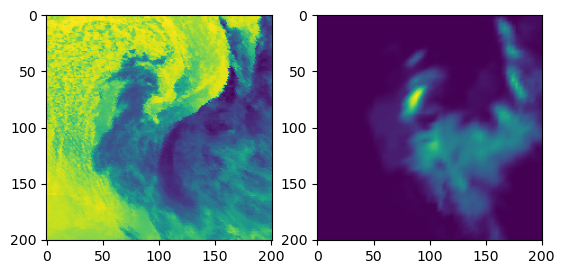

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(datacube[0, :, :, 0])
axes[1].imshow(datacube[0, :, :, 1])

Clearly the IR and PMW channels do not provide the same information.

## Datacube

According to the authors, there are some damaged values in the images. According to the authors, there are two types of them:
* ```NaN``` values
* Extremely large outliers

In the original paper, the authors replace NaNs and values above $10^3$ with zeros.  

### Extreme outliers

Let's first check for extremely large values, as we could convert outliers to NaNs and then treat all of them at once.  
For that, we'll plot the distribution of the pixel intensities, separately for each channel.

Text(0.5, 0, 'PMW pixel intensity')

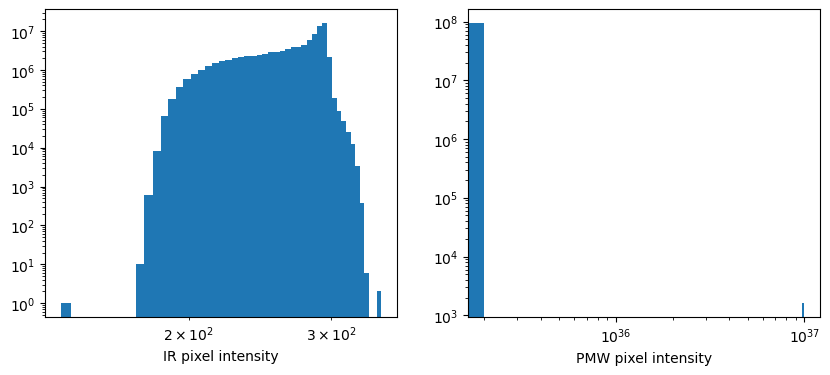

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].hist(datacube[:, :, :, 0].data.flatten(), bins=50)
axes[1].hist(datacube[:, :, :, 1].data.flatten(), bins=50)
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_xlabel('IR pixel intensity')
axes[1].set_xlabel('PMW pixel intensity')

In the IR channel, there seem to be some outliers, but very, very few of them, and their value is close to 0, so they should barely have any impact on the training.  
There are obvious outliers in the Passive Microwave rainrate channel however, which we'll convert to ```NaN```, so that they are treated afterwards. We'll use $10^3$ as the treshold for outliers, which is the value used in the original paper.

In [21]:
datacube = datacube.where(datacube[:, :, :, 1] < 10^3)

### NaNs
Let's count the proportion of NaNs in each image, and plot the distribution of that proportion:

In [22]:
nan_counts = np.array([datacube[k].isnull().sum() for k in range(datacube.shape[0])])
nan_ratios = nan_counts / (datacube.shape[1] * datacube.shape[2] * 2)

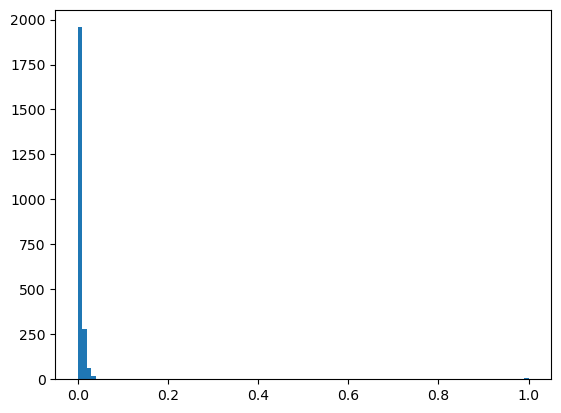

In [23]:
plt.hist(nan_ratios, bins=np.linspace(0, 1, 100))
plt.show()

It appears that few samples contain NaNs, but for some of those, they are fully missing.

We'll be proceeding in the following way:
* For every storm S that contains at least one sample that is more than 10% NaN:
    * Find all segments of S's trajectory that do not contain any NaN;
    * Consider each of those segments as an independent trajectory, by giving them new SIDs.
    * Discard the samples containing NaNs (and that are thus fully NaN).
* Where the images contain less than 10% of NaNs, fill them with zeros.

In [24]:
# Retrieve the index of the samples that are fully NaN.
where_full_nan = np.where(nan_ratios >= 0.1)[0]
# Retrieve the SIDs corresponding to those samples
sids_with_full_nan = data_info.iloc[where_full_nan]['SID'].unique()

We should check how the intensity of the samples than contain many NaNs is distributed, to know if discarding them would bias the dataset:

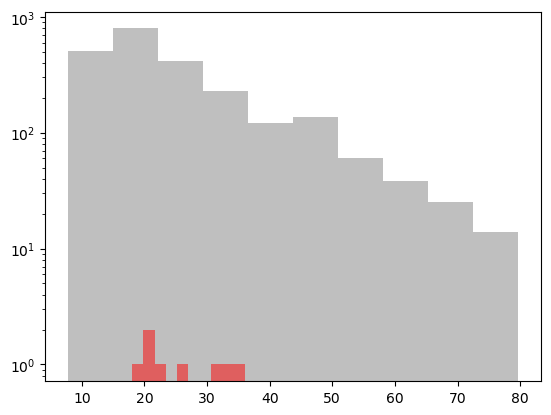

In [25]:
# Plot the general distribution of the intensity
plt.hist(data_info['INTENSITY'], alpha=0.5, color="grey")
# Plot the distribution of the intensity of the missing storms
plt.hist(data_info.iloc[where_full_nan]['INTENSITY'], alpha=0.5, color="red")
plt.yscale('log')
plt.show()

Clearly, they do not bias the dataset as there is very few of them (notice the log scale), and they are situated around the mode of the distribution.  
We can now proceed to removing them:

In [26]:
for sid in sids_with_full_nan:
    segments = []
    current_segment = []
    currently_in_segment = False
    # Iterate through the samples of that storm. If we find a NaN, that's the end
    # of the current segment. Keep iterating until finding a non full-NaN sample,
    # which is the start of a new segment.
    for k in data_info[data_info['SID'] == sid].index:
        if k in where_full_nan:
            if currently_in_segment:
                # Stop the current segment
                segments.append(np.array(current_segment))
                current_segment = []
                currently_in_segment = False
        else:
            if not currently_in_segment:
                # Start a new segment if not currently in a segment
                currently_in_segment = True
            current_segment.append(k)

    sid_values = data_info['SID'].values.copy()
    for n_seg, seg in enumerate(segments):
        # Give all samples in that segment a new SID
        sid_values[seg] = sid_values[seg] + f'_{n_seg}'
    data_info['SID'] = sid_values
# Drop the samples that are fully NaNs
data_info = data_info.drop(index=where_full_nan)

In [27]:
data_info.shape

(2329, 9)

In [28]:
# Select the index of data_info (which doesn't contain the full-NaN samples anymore) in the datacube
datacube = datacube.isel(sid_time=data_info.index)
datacube.shape

(2329, 201, 201, 2)

In [29]:
# Reset the index of the tabular data, so that it matches that of the datacube
data_info = data_info.reset_index()

In [30]:
# We can now interpolate the partially-NaN images
datacube = datacube.interpolate_na('h_pixel_offset', method='linear')
# NaN values at the border won't be interpolated, we'll fill them with zeros.
datacube = datacube.fillna(0)

In [31]:
datacube.isnull().sum()

<xarray.DataArray 'matrix' ()>
array(0)